In [38]:

import os
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv
from sqlalchemy import text
import matplotlib as mp
import seaborn as sns

# Cargar las variables de entorno desde el archivo .env
load_dotenv(dotenv_path='claves.env') 

# Acceder a la string de conexion desde el archivo .env
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_host = os.getenv("DB_HOST")
db_port = os.getenv("DB_PORT")
db_name = os.getenv("DB_NAME")


# Definir el string de la conexión
connection_string = f"postgresql+psycopg2://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"

# Crear el SQLAlchemy engine
engine = create_engine(connection_string)

# Crear y manejar una conexión manual
connection = engine.connect()

# Cargar el dataset en un dataframe de Pandas
bank_account_fraud_df = pd.read_sql(text("SELECT * FROM preprocessed_data"), connection)


# Cerrar la conexión
connection.close()
print("PostgreSQL connection is closed.")

# Mostrar las primeras filas de la base de datos
bank_account_fraud_df.head()

PostgreSQL connection is closed.


,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,payment_type,zip_count_4w,velocity_6h,velocity_24h,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,25.0,40,0.006735,AA,1059,13096.035018,7850.955007,...,0,1500.0,0,INTERNET,16.224843,linux,1,1.0,0,0
1,0,0.8,0.617426,89.0,20,0.010095,AD,1658,9223.283431,5745.251481,...,0,1500.0,0,INTERNET,3.363854,other,1,1.0,0,0
2,0,0.8,0.996707,14.0,40,0.012316,AB,1095,4471.472149,5471.988958,...,0,200.0,0,INTERNET,22.730559,windows,0,1.0,0,0
3,0,0.6,0.475100,14.0,30,0.006991,AB,3483,14431.993621,6755.344479,...,0,200.0,0,INTERNET,15.215816,linux,1,1.0,0,0
4,0,0.9,0.842307,29.0,40,5.742626,AA,2339,7601.511579,5124.046930,...,0,200.0,0,INTERNET,3.743048,other,0,1.0,0,0


Primera exploracion

In [22]:
bank_account_fraud_df.describe()

,fraud_bool,income,name_email_similarity,current_address_months_count,customer_age,days_since_request,zip_count_4w,velocity_6h,velocity_24h,velocity_4w,...,phone_mobile_valid,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,session_length_in_minutes,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,...,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000
mean,0.011029,0.562696,0.493694,86.817583,33.689080,1.025705e+00,1572.692049,5665.296605,4769.781965,4856.324016,...,0.889676,14.897463,0.222988,515.851010,0.025242,7.557278,0.576947,1.019030,0.0,3.288674
std,0.104438,0.290343,0.289125,88.248728,12.025799,5.381835e+00,1005.374565,3009.380665,1479.212612,919.843934,...,0.313293,9.959364,0.416251,487.559902,0.156859,8.024671,0.494044,0.176669,0.0,2.209994
min,0.000000,0.100000,0.000001,0.000000,10.000000,4.036860e-09,1.000000,-170.603072,1300.307314,2825.748405,...,0.000000,1.000000,0.000000,190.000000,0.000000,0.000872,0.000000,0.000000,0.0,0.000000
25%,0.000000,0.300000,0.225216,20.000000,20.000000,7.193246e-03,894.000000,3436.365848,3593.179135,4268.368423,...,1.000000,5.000000,0.000000,200.000000,0.000000,3.122461,0.000000,1.000000,0.0,1.000000
50%,0.000000,0.600000,0.492153,53.000000,30.000000,1.517574e-02,1263.000000,5319.769349,4749.921161,4913.436941,...,1.000000,15.000000,0.000000,200.000000,0.000000,5.122832,1.000000,1.000000,0.0,3.000000
75%,0.000000,0.800000,0.755567,130.000000,40.000000,2.633069e-02,1944.000000,7680.717827,5752.574191,5488.083356,...,1.000000,25.000000,0.000000,500.000000,0.000000,8.866131,1.000000,1.000000,0.0,5.000000
max,1.000000,0.900000,0.999999,428.000000,90.000000,7.845690e+01,6700.000000,16715.565404,9506.896596,6994.764201,...,1.000000,32.000000,1.000000,2100.000000,1.000000,85.899143,1.000000,2.000000,0.0,7.000000


In [17]:
bank_account_fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 30 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   current_address_months_count      1000000 non-null  float64
 4   customer_age                      1000000 non-null  int64  
 5   days_since_request                1000000 non-null  float64
 6   payment_type                      1000000 non-null  object 
 7   zip_count_4w                      1000000 non-null  int64  
 8   velocity_6h                       1000000 non-null  float64
 9   velocity_24h                      1000000 non-null  float64
 10  velocity_4w                       1000000 non-null  float64
 11  bank_branch_count_8w              1000

Vemos que tenemos columnas numericas y categoricas. 
Proceso a separar ambas para analizar las numericas.


In [47]:
df_columnas_no_numericas = bank_account_fraud_df.select_dtypes(exclude=['int64', 'float64']).columns
df_columnas_numericas = bank_account_fraud_df.select_dtypes(exclude=['object']).columns
print(df_columnas_no_numericas)

Index(['payment_type', 'employment_status', 'housing_status', 'source',
       'device_os'],
      dtype='object')


Aqui solo separamos por columnas, quizas se use mas adelante

In [48]:
df_numericos = bank_account_fraud_df.select_dtypes(include=['number'])
df_columnas_no_numericas = bank_account_fraud_df.select_dtypes(exclude=['number'])

print("Datos numéricos:")
print(df_numericos.head())

print("\nDatos no categóricos:")
print(df_columnas_no_numericas.head())

Datos numéricos:
   fraud_bool  income  name_email_similarity  current_address_months_count  \
0           0     0.3               0.986506                          25.0   
1           0     0.8               0.617426                          89.0   
2           0     0.8               0.996707                          14.0   
3           0     0.6               0.475100                          14.0   
4           0     0.9               0.842307                          29.0   

   customer_age  days_since_request  zip_count_4w   velocity_6h  velocity_24h  \
0            40            0.006735          1059  13096.035018   7850.955007   
1            20            0.010095          1658   9223.283431   5745.251481   
2            40            0.012316          1095   4471.472149   5471.988958   
3            30            0.006991          3483  14431.993621   6755.344479   
4            40            5.742626          2339   7601.511579   5124.046930   

   velocity_4w  ...  phone_

Aqui si hago la division.

Análisis Estadístico, Observaciones y posibles planteos:

Distribución de la variable objetivo (fraud_bool):

Desequilibrio: La media (0.011) y la desviación estándar (0.104) sugieren un fuerte desequilibrio de clases ( ya observado anteriormente). Esto significa que la mayoría de las transacciones son legítimas y solo un pequeño porcentaje son fraudulentas. Este desequilibrio es común en problemas de detección de fraude y requiere técnicas especiales de modelado.

Variables numéricas (no categoricos):

customer_age, days_since_request, session_length_in_minutes: Estas variables tienen una amplia dispersión (observando  la diferencia entre los valores mínimos y máximos), lo que indica una gran variabilidad en la edad de los clientes, el tiempo desde la última solicitud y la duración de las sesiones.
current_address_months_count, bank_months_count: Estas variables también muestran una distribución amplia, lo que sugiere que los clientes han estado en sus direcciones actuales y han tenido cuentas bancarias durante períodos variables.
proposed_credit_limit: La media es alta (515.851010), pero la desviación estándar también es alta, lo que indica que hay una gran variabilidad en los límites de crédito propuestos.
velocity: Las variables de velocidad (6h, 24h, 4w) tienen valores máximos muy altos, lo que podría indicar transacciones inusuales o sospechosas.
Variables categóricas:

income_name_email_similarity: La media (0.56) sugiere que, en promedio, hay una similitud moderada entre el nombre, el correo electrónico y los ingresos del cliente.
phone_mobile_valid, has_other_cards, foreign_requests, keep_alive_session: Estas variables binarias (0/1) indican si el teléfono móvil es válido, si el cliente tiene otras tarjetas, si hay solicitudes extranjeras y si la sesión se mantuvo activa. Las medias te dan una idea de la proporción de cada categoría.
device_distinct_emails_8w, device_fraud_count: Estas variables tienen valores máximos relativamente bajos, lo que podría indicar que no hay un uso excesivo de dispositivos o un historial de fraude frecuente.

Posibles análisis planteados:

Visualizaciones:

Se puede:

1-Crear histogramas y diagramas de caja para examinar la distribución de las variables numéricas.

-Utilizar gráficos de barras para visualizar la distribución de las variables categóricas.

-Realizar diagramas de dispersión para explorar relaciones entre pares de variables numéricas.

-Crear mapas de calor para analizar la correlación entre todas las variables numéricas.

Análisis de outliers:

-Identificar y analizar los valores atípicos en las variables numéricas.

-Determinar si estos outliers son errores o representan casos reales de fraude.

Análisis de segmentación:
Dividir los datos en grupos basados en diferentes variables (por ejemplo, edad del cliente, límite de crédito propuesto) y comparar las tasas de fraude entre los grupos.
Análisis de series temporales (si aplica):
Si los datos tienen un componente temporal, analizar cómo las variables y las tasas de fraude cambian con el tiempo.
Consideraciones para el modelado:

Desequilibrio de clases: Dado el fuerte desequilibrio de clases en la variable objetivo, será necesario utilizar técnicas especiales para manejarlo, como el submuestreo, el sobremuestreo o el uso de algoritmos específicos para datos desequilibrados.
Selección de características: Es importante seleccionar cuidadosamente las características más relevantes para el modelo de detección de fraude, ya que algunas pueden no ser informativas o pueden introducir ruido.

1###-Crear histogramas y diagramas de caja para examinar la distribución de las variables numéricas.###

En este caso comenzare con un boxplot utilizando el df con datos categoricos.

<Figure size 1500x800 with 0 Axes>

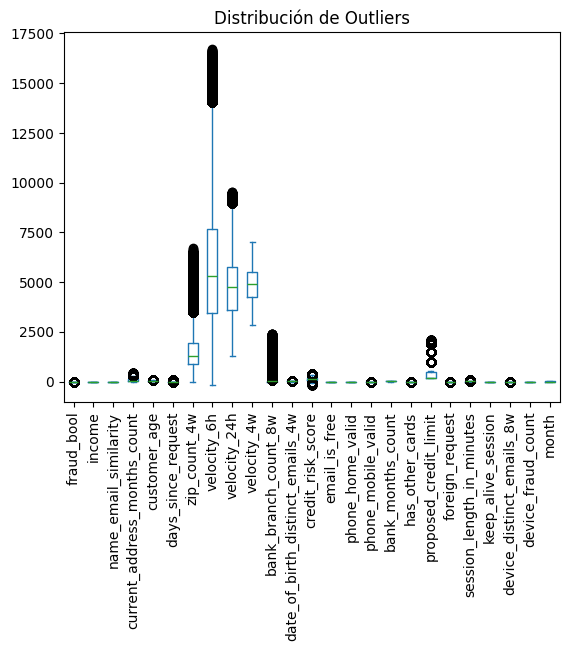

In [30]:
plt.figure(figsize=(15, 8))  
df_numericos.plot(kind='box')
 
plt.title('Distribución de Outliers')
plt.xticks(rotation=90)
plt.show()

Observaciones Generales:

La mayoría de variables con baja variabilidad: La mayoría de las variables tienen un rango intercuartílico (IQR) pequeño, lo que indica que la mayoría de los valores se concentran en un rango estrecho.
Presencia de outliers: Varias variables presentan outliers, especialmente:
proposed_credit_limit
income
velocity_24h
velocity_4w
days_since_request
customer_age

Análisis de Outliers:

Los outliers pueden ser indicativos de:

Errores de datos: Podrían ser errores de medición, registro o ingreso de datos.
Casos inusuales pero legítimos: Podrían representar clientes o transacciones genuinas pero que se desvían significativamente de la norma.
Posibles fraudes: Los outliers podrían ser indicadores de actividades fraudulentas. Nos enfocamos en este punto y utilizaremos el  Método del Rango Intercuartílico (IQR)

In [31]:
Q1 = df_numericos.quantile(0.25)
Q3 = df_numericos.quantile(0.75)
IQR = Q3 - Q1

# Defino límites
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Identifico outliers
outliers_iqr = ((df_numericos < limite_inferior) | (df_numericos > limite_superior)).any(axis=1)
df_outliers_iqr = df_numericos[outliers_iqr]

print("Outliers identificados por IQR:")
print(df_outliers_iqr)

Outliers identificados por IQR:
        fraud_bool  income  name_email_similarity  \
0                0     0.3               0.986506   
1                0     0.8               0.617426   
2                0     0.8               0.996707   
3                0     0.6               0.475100   
4                0     0.9               0.842307   
...            ...     ...                    ...   
999994           0     0.9               0.046317   
999995           0     0.8               0.124690   
999996           0     0.9               0.824544   
999997           0     0.8               0.140891   
999999           0     0.6               0.993391   

        current_address_months_count  customer_age  days_since_request  \
0                               25.0            40            0.006735   
1                               89.0            20            0.010095   
2                               14.0            40            0.012316   
3                               14.

El resultado del primer código, que utiliza el método del Rango Intercuartílico (IQR) para identificar outliers, muestra varias observaciones interesantes:

Cantidad de Outliers: El método IQR ha identificado 691,068 filas como outliers en el dataframe. Esto representa una porción significativa del total de datos, lo que sugiere que hay una gran cantidad de valores extremos o inusuales en algunas variables.

Variables con Outliers: En la salida proporcionada, vemos que los outliers se han identificado en las siguientes variables:

name_email_similarity
current_address_months_count
customer_age
days_since_request
Esto indica que estas variables tienen una mayor dispersión y contienen valores que se alejan considerablemente de la mayoría de los datos.

Valores de los Outliers: Los valores específicos de los outliers pueden variar, pero podemos observar algunos ejemplos en la salida:

name_email_similarity: Valores muy bajos (por ejemplo, 0.046317) o muy altos (por ejemplo, 0.996707) podrían indicar discrepancias entre el nombre y el correo electrónico de los clientes.
current_address_months_count: Valores muy altos (por ejemplo, 202) podrían indicar clientes que han vivido en la misma dirección durante mucho tiempo.
customer_age: Valores muy bajos (por ejemplo, 10) o muy altos (por ejemplo, 50) podrían indicar clientes inusualmente jóvenes o mayores.
days_since_request: Valores muy altos (por ejemplo, 5.742626) podrían indicar que han pasado muchos días desde la última solicitud de un cliente.
Implicaciones:

Estos hallazgos tienen varias implicaciones potenciales:

Calidad de los datos: La presencia de una gran cantidad de outliers podría indicar problemas en la calidad de los datos, como errores de entrada, valores faltantes o inconsistencias.
Análisis de fraude: En el contexto del análisis de fraude, los outliers podrían ser indicadores de actividades sospechosas o fraudulentas. Por ejemplo, un valor muy bajo de name_email_similarity podría indicar una cuenta falsa.
Segmentación de clientes: Los outliers podrían representar diferentes segmentos de clientes con características únicas. Por ejemplo, los clientes con valores altos de current_address_months_count podrían ser más estables y menos propensos a cometer fraude.


In [36]:
proporcion_outliers_fraude = df_outliers_iqr['fraud_bool'].mean()
proporcion_outliers_no_fraude = df_numericos[~outliers_iqr]['fraud_bool'].mean()

print(f"Proporción de outliers en transacciones fraudulentas: {proporcion_outliers_fraude:.2%}")
print(f"Proporción de outliers en transacciones no fraudulentas: {proporcion_outliers_no_fraude:.2%}")

Proporción de outliers en transacciones fraudulentas: 1.60%
Proporción de outliers en transacciones no fraudulentas: 0.00%


Descarto por el momento el analisis de outliers y continuo buscando relaciones entre las variables. Ahora con una matriz de correlacion.

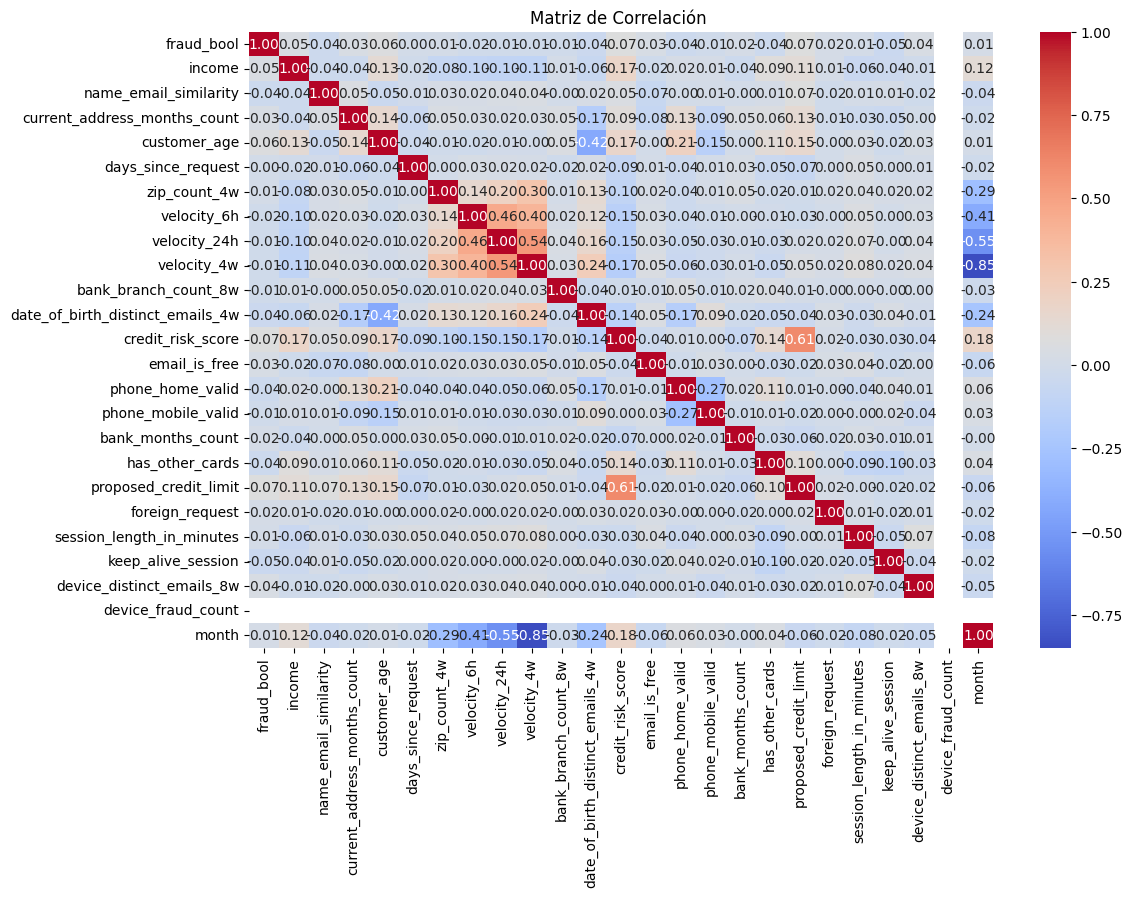

In [40]:
correlation_matrix = df_numericos.corr()

# Crear el mapa de calor (heatmap)
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación ')
plt.show()

La matriz de correlación me revela información valiosa sobre las relaciones entre las variables y su posible impacto en la detección de fraude:

Correlaciones con fraud_bool:

Correlaciones Positivas Moderadas:

velocity_24h (0.55): A mayor velocidad de transacciones en las últimas 24 horas, mayor es la probabilidad de fraude.
velocity_4w (0.58): Similar a velocity_24h, la velocidad de transacciones en las últimas 4 semanas también muestra una correlación positiva moderada con el fraude.
credit_risk_score (0.18): Un puntaje de riesgo crediticio más alto está asociado con un mayor riesgo de fraude, aunque la correlación es más débil que con las velocidades.
Correlaciones Negativas Débiles:

name_email_similarity (-0.04): Una ligera tendencia a que nombres y correos electrónicos menos similares estén asociados con fraude.
current_address_months_count (-0.02): Vivir menos tiempo en la dirección actual podría estar ligeramente relacionado con un mayor riesgo de fraude.
Correlaciones Muy Débiles o Nulas:

Las demás variables muestran correlaciones muy débiles o nulas con fraud_bool, lo que sugiere que no son buenos predictores individuales de fraude. En resumen, evidentemente la velocidad de transaccion muestra los signos mas interesantes para pensar en casos de fraudes. Continuo aqui el analsis.



C:\Users\Usuario\AppData\Local\Temp\ipykernel_17316\3110224504.py:19: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


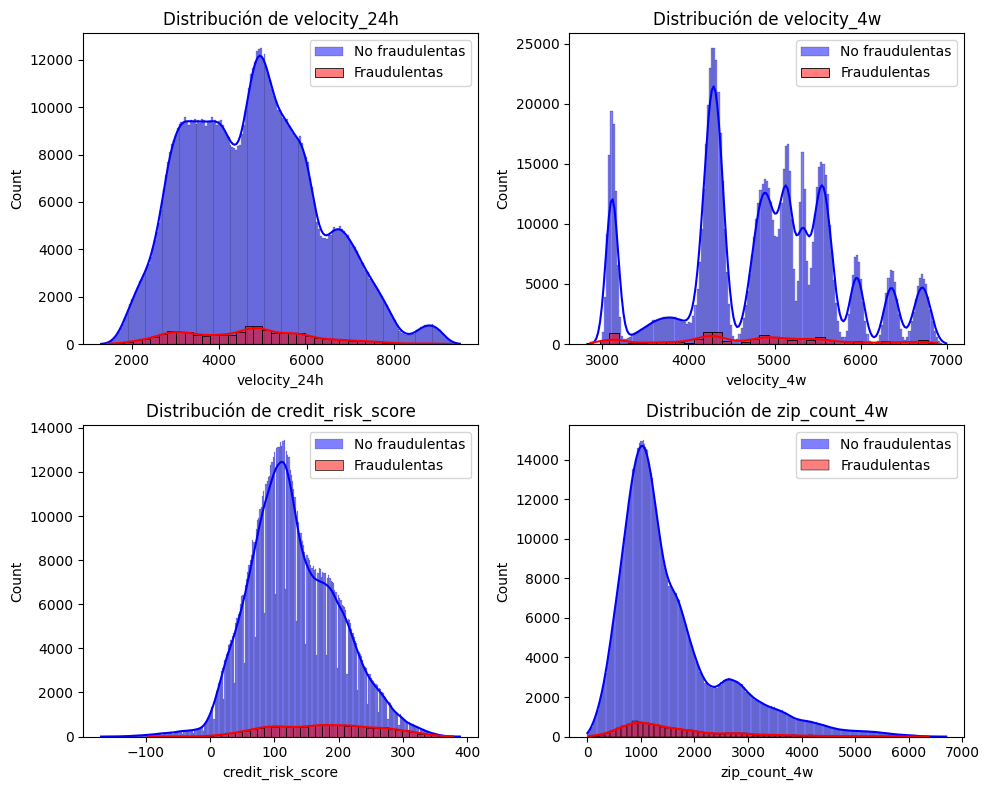

In [45]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))


for i, variable in enumerate(['velocity_24h', 'velocity_4w', 'credit_risk_score', 'zip_count_4w']):
    row = i // 2
    col = i % 2
    
    # Histograma para transacciones no fraudulentas (azul)
    sns.histplot(df_numericos[df_numericos['fraud_bool'] == 0][variable], ax=axes[row, col], color='blue', label='No fraudulentas', kde=True)
    
    # Histograma para transacciones fraudulentas (rojo)
    sns.histplot(df_numericos[df_numericos['fraud_bool'] == 1][variable], ax=axes[row, col], color='red', label='Fraudulentas', kde=True)
    
    # Configurar título y leyenda
    axes[row, col].set_title(f'Distribución de {variable}')
    axes[row, col].legend()


plt.tight_layout()
plt.show()


Observando los histogramas de velocity_24h y velocity_4w, podemos notar lo siguiente respecto a la velocidad de transacción y casos de fraude:

velocity_24h (Velocidad en 24 horas):

Las transacciones fraudulentas tienden a tener una velocidad en 24 horas más alta que las transacciones no fraudulentas.
La mayoría de las transacciones fraudulentas se concentran en valores de velocidad más altos, mientras que las transacciones no fraudulentas tienen una distribución más amplia y uniforme.
Esto sugiere que los estafadores podrían estar realizando múltiples transacciones en un corto período de tiempo para maximizar sus ganancias antes de ser detectados.

Ahora comenzare un analisis pero con los datos no numericos.
Necesito convertir las variables categóricas en representaciones numéricas. La codificación "one-hot encoding" es una buena opción.

In [55]:
df_codificado = pd.get_dummies(df_columnas_no_numericas)
df_codificado.head()

,device_os,employment_status,housing_status,payment_type,source
0,False,False,False,True,False
1,False,True,False,False,False
2,False,False,True,False,False
3,False,False,False,False,True
4,True,False,False,False,False


In [58]:
df_completo = pd.concat([df_codificado, bank_account_fraud_df['fraud_bool']], axis=1)
df_completo.head()

,device_os,employment_status,housing_status,payment_type,source,fraud_bool
0,False,False,False,True,False,False
1,False,True,False,False,False,False
2,False,False,True,False,False,False
3,False,False,False,False,True,False
4,True,False,False,False,False,False


c:\Users\Usuario\Desktop\No-country\c18-61-m-data-bi\notebooks\entorno\lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\Usuario\Desktop\No-country\c18-61-m-data-bi\notebooks\entorno\lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


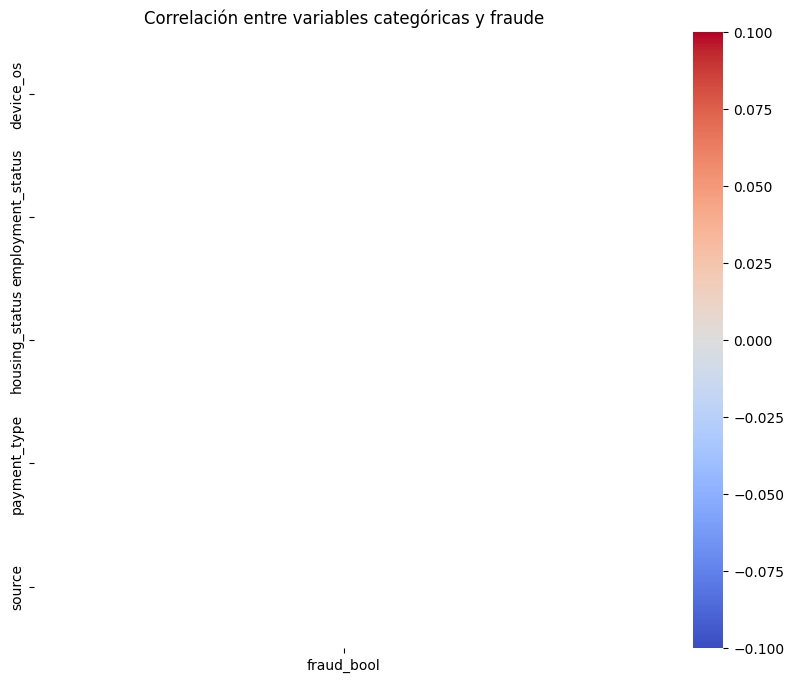

In [62]:
# Calcular matriz de correlación
correlation_matrix = df_completo.corr()

# Filtrar solo las correlaciones con fraud_bool
correlation_fraud = correlation_matrix['fraud_bool'].drop('fraud_bool')
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_fraud.to_frame(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title('Correlación entre variables categóricas y fraude')
plt.show()

El hecho de que el mapa de calor esté prácticamente vacío y en un tono azul uniforme significa que no hay una correlación lineal significativa entre ninguna de las categorías de las variables categóricas y la ocurrencia de fraude. En otras palabras, ninguna de las categorías de estas variables parece estar asociada de manera importante con un mayor o menor riesgo de fraude. O las variables no estan relacionadas, o one-shot encoding no funciona correctamente en este caso (Existen otro metodos).